# Grafo: Unidades Nutricionais por rede de Fast Food 

O objetivo foi criar um grafo que representasse o nível de nutrientes presente em cada lanche das redes selecionadas (Mc Donalds e Burguer King).

O gráfico que aparece ao final desse notebook contém todos os dados disponíveis no banco, portanto, está visualmente p oluido e, assim, não cumpre os objetivos. Porém, as próximas etapas consistem em criar filtros para resolver esse problema. 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Como fizemos a leitura e limpeza de dados no notebook "Dados_MYSQL", aqui só precisamos importa-los:

In [2]:
df = pd.read_csv("fastfood.csv", index_col="name")

Queremos criar nodes que representem cada nutriente, de forma que o tamanho deles seja determinado pela sua quantidade contida em todos os lanches. Para tornar isso possível, somamos essas quantidades e normalizamos os dados.

In [3]:
soma_list,nutri = [],[]

for nutriente in df.columns[0:len(df.columns)-2]: #para cada nutriente no dataframe (-2 para excluir "categoria" e "rede")
    soma_list.append(df[nutriente].sum()) #soma os valores totais 
    nutri.append(nutriente) #guardamos o nome do nutriente

soma_list = pd.Series(soma_list)
  
soma_norm = (soma_list - soma_list.mean())/ soma_list.std() #normalização dos dados totais
soma_min = abs(soma_norm.min())

soma_norm = round((soma_norm + soma_min + 1)*700) #deixa todos os valores > 0 
    
soma_nutri = dict(zip(nutri,soma_norm)) #criamos um dicionário com o nutriente e sua soma total normalizada

Agora precisamos simplismente criar o grafo, os nós e as arestas.

In [4]:
fastfood = nx.Graph()  #criar o grafo

#criar os nós para cada unidade nutricional  
for nutrientes in df.columns[0:len(df.columns)-2]:
    if soma_nutri[nutrientes] >0:
        fastfood.add_node(nutrientes,color="grey",size=soma_nutri[nutrientes])
    # soma_nutri possui os dados normalizads criados anteriormente
    
# criar os nós para cada lanche    
for lanche in df.index:
    fastfood.add_node(lanche, color= df.loc[lanche,"rede"],size=700,categoria=df.loc[lanche,"categoria"]) #criando os nós de cada lanche 
     # o atributo categoria será usado futuramente para filtrar o grafo
         
        
#criar uma aresta ligando os lanches e os nós
for lanche in df.index:
    for nutriente in df.columns[0:len(df.columns)-2]:
        local = (df.copy()).dropna() # não faz sentido criar uma aresta se não temos o valor
        if local.loc[lanche,nutriente] > 0: #tbm não faz se o valor for zero
            fastfood.add_edge(lanche, nutriente, weight = local.loc[lanche,nutriente])
            # atribuimos o peso como o peso do nutriente, que foi normalizado
            

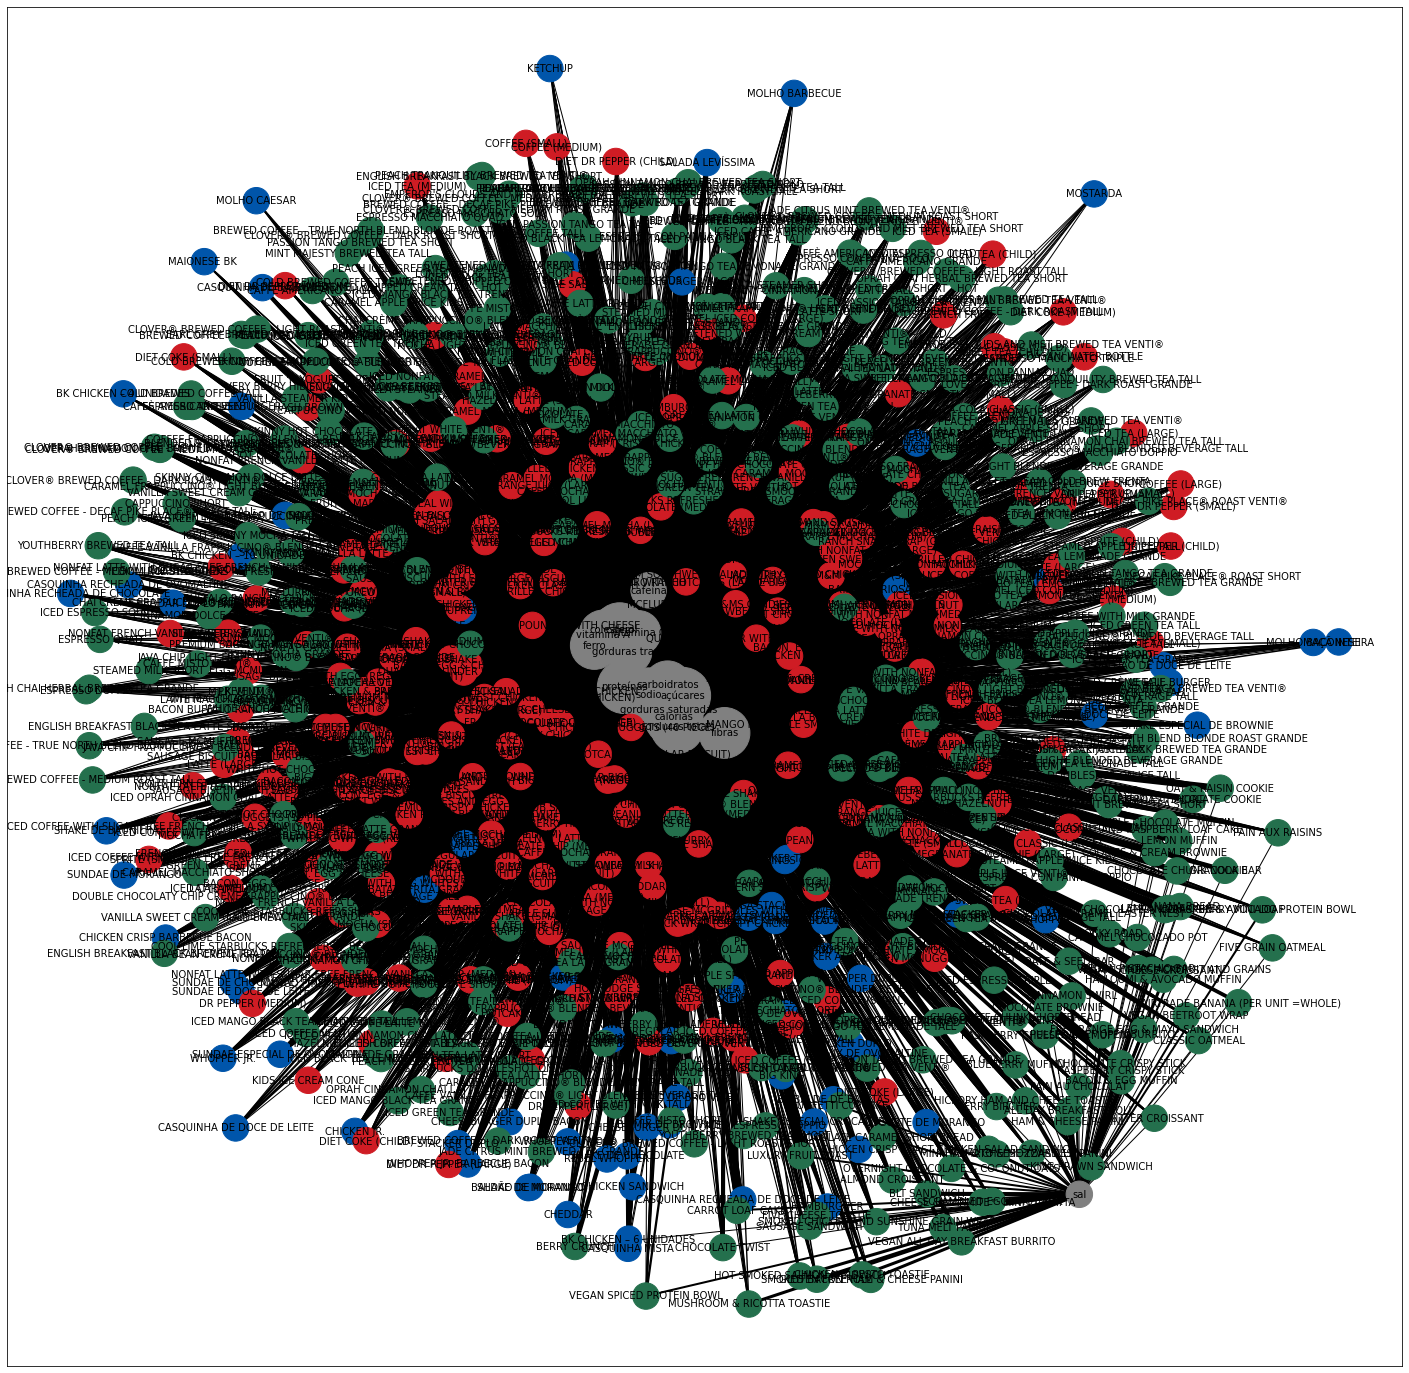

In [5]:
#plotar o grafo        
fig, ax = plt.subplots(figsize=(25,25))

pos = nx.spring_layout(fastfood)

for node in fastfood.nodes:
    fastfood.nodes[node]['pos'] = list(pos[node])

nx.draw_networkx(fastfood,  
                  arrows=True,
                  pos=pos,
                  with_labels=True,
                  ax=ax,
                  node_size=[nx.get_node_attributes(fastfood,'size')[g] for g in fastfood.nodes()], 
                  node_shape='o',
                  node_color=[nx.get_node_attributes(fastfood,'color')[g] for g in fastfood.nodes()],
                  alpha=1.0,
                  width=list(nx.get_edge_attributes(fastfood,'weight').values()),
                  style='solid',
                  font_size=10,
                  font_color='black',
                  font_weight='normal',
                  font_family='sans-serif')

# Dash com Plotly 

### Seria mais interessante se o nome aparecesse só no hoverinfo, mas ainda nao consegui fazer 

In [6]:
#https://plotly.com/python/network-graphs/

#https://plotly.com/python/hover-text-and-formatting/

In [6]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output

In [7]:
def make_edge(x, y, width):
    return  go.Scatter(x = x,
                       y  = y,
                       line = dict(width = width,
                                   color = "black"),
                       mode  = 'lines')

In [8]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

#acho que isso é pra escolher o estilo, eu só copiei do github do jupyter_dash

In [9]:
app.layout = html.Div([
    html.Div([
        dcc.Checklist( #fazer a opção de selecionar os nutrientes
            id='select_nutri',
            options=[{'label': i, 'value': i} for i in df.columns[0:len(df.columns)-2]],
            value=['calorias'],
            labelStyle={'display': 'inline-block'}),
    ]),
    html.Div([
        dcc.Checklist( #fazer a opção de selecionar as rede, deixei a mão pq é curto
            id='select_chain',
            options=[
                {'label': 'BURGERKING', 'value': '#0055AA'},
                {'label': 'MCDONALDS', 'value': '#CF1C24'},
                {'label': 'STARBUCKS', 'value': '#24704D'}
            ],
            value=['#0055AA'],
            labelStyle={'display': 'inline-block'}),
    ]),
    html.Div([
        dcc.Graph(id='my-output'),
    ])
])

@app.callback(
    Output('my-output', 'figure'),
    Input('select_nutri', 'value'),
    Input('select_chain', 'value'),
)
def update_output_div(sel_n, sel_c):
    edge_trace = []    
    for edge in fastfood.edges():
        if edge[0] in sel_n:
            if df.loc[edge[1],'rede'] in sel_c:
                x0, y0 = fastfood.nodes[edge[0]]['pos']
                x1, y1 = fastfood.nodes[edge[1]]['pos']

                trace  = make_edge([x0, x1, None], [y0, y1, None], width = fastfood.get_edge_data(edge[0],edge[1])['weight'])
                edge_trace.append(trace)

    node_trace = go.Scatter(x         = [],
                            y         = [],
                            text= [],
                            textposition = "top center",
                            textfont_size = 10,
                            mode      = 'markers',
                            hoverinfo = 'text',
                            marker    = dict(color = [],
                                             size  = [],
                                             line  = None))


    for node in fastfood.nodes():
        if fastfood.nodes[node]['color']=='grey':
            if node in sel_n:
                x, y = pos[node]
                node_trace['x'] += tuple([x])
                node_trace['y'] += tuple([y])
                node_trace['marker']['color'] += tuple([fastfood.nodes[node]['color']])
                node_trace['marker']['size'] += tuple([fastfood.nodes[node]['size']/100])
                node_trace['text'] += tuple([node])
        else:
            if fastfood.nodes[node]['color'] in sel_c:
                x, y = pos[node]
                node_trace['x'] += tuple([x])
                node_trace['y'] += tuple([y])
                node_trace['marker']['color'] += tuple([fastfood.nodes[node]['color']])
                node_trace['marker']['size'] += tuple([fastfood.nodes[node]['size']/50])
                node_trace['text'] += tuple([node])

    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)', # transparent background
        plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
        xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
        yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
        width=1000, 
        height=750 #AQUI DEFINE O TAMANHO QUE VAI MOSTRAR O GRAFO
    )


    fig = go.Figure(layout = layout)


    # Add all edge traces
    for trace in edge_trace:
        fig.add_trace(trace)
    # Add node trace
    fig.add_trace(node_trace)
    # Remove legend
    fig.update_layout(showlegend = False)
    # Remove tick labels
    fig.update_xaxes(showticklabels = False)
    fig.update_yaxes(showticklabels = False)

    # return figure
    return fig

    
if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/
